## Panan Temperature Quick

In [1]:
import intake

import matplotlib.pyplot as plt
import xarray as xr
import cf_xarray as cfxr
import numpy as np

import cmocean as cm
import cartopy.crs as ccrs

import cartopy.feature as cft
import matplotlib.path as mpath

In [2]:
#Importing data
pancontrol01 = intake.open_esm_datastore('/home/272/kc5856/panantrial/experiment_datastore.json', columns_with_iterables=['variable'])
pantrial01 = intake.open_esm_datastore('/home/272/kc5856/catalog_dir/experiment_datastore.json', columns_with_iterables=['variable'])
pancontrol005 = intake.open_esm_datastore('/home/272/kc5856/catalog_dir/panant_005_zstar_access_yr2.json', columns_with_iterables=['variable'])
pantrial005 = intake.open_esm_datastore('/home/272/kc5856/panantrial/panant_005_zstar_MWonly.json', columns_with_iterables=['variable'])

In [3]:
#Starting a dask client
from os import environ
environ["PYTHONWARNINGS"] = "ignore"

from dask.distributed import Client
client = Client(threads_per_worker=1)

/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 35331 instead
  warnings.warn(


### Defining variables

In [4]:
#Time variant variables #ASK HOW TO CONDENSE
control01_temp = pancontrol01.search(variable="thetao", frequency="1mon").to_dask()#add chunks line in to.dask()
trial01_temp = pantrial01.search(variable="thetao", frequency="1mon").to_dask()
control005_temp = pancontrol005.search(variable=["thetao"],frequency="1mon",file_id=["XXXXXXXX_ocean_month_z"]).to_dask()
trial005_temp = pantrial005.search(variable="thetao", frequency="1mon").to_dask()

In [5]:
#Time in variant variables
data01_fixed = pancontrol01.search(variable=["areacello","deptho"],path=".*output021.*").to_dask()
data005_fixed = pancontrol005.search(variable=["areacello","deptho"],path=".*output021.*").to_dask()
vol01 = pancontrol01.search(variable=["volcello"],path=".*output021.*",file_id=["XXXXXXXX_ocean_month_z"]).to_dask()
vol005 = pancontrol005.search(variable=["volcello"],path=".*output021.*",file_id=["XXXXXXXX_ocean_month_z"]).to_dask()

In [6]:
#Area weighting
areacello01 = data01_fixed.areacello
areacello005 = data005_fixed.areacello
vol01 = vol01
vol005 = vol005
thick01 = vol01 / areacello01
thick005 = vol005 / areacello005

In [7]:
thick01 = thick01.load()
thick005 = thick005.load()

### Defining shelf mask

In [8]:
def shelf_mask_isobath(var, model_dict):

    paths = {
             "mom5": "/g/data/ik11/grids/Antarctic_slope_contour_1000m.npz",
             "mom6": "/g/data/ik11/grids/Antarctic_slope_contour_1000m_MOM6_01deg.nc",
            "mom6_005": "/g/data/ik11/grids/Antarctic_slope_contour_1000m_MOM6_005deg.nc"
             }

    var = var.cf.sel({'latitude': slice(-90, -59)})

    if paths[model_dict][-3:] == '.nc':
        shelf_mask = xr.open_dataset(paths[model_dict])['contour_masked_above']
    else:
        contour_file = np.load(paths[model_dict])
        shelf_mask = xr.DataArray(contour_file['contour_masked_above'],
                                  coords = var.coords, 
                                  dims = var.dims,
                                  name = 'contour_masked_above')
    
    shelf_mask = xr.where(shelf_mask == 0, 1, 0)
    masked_var = var * shelf_mask
    
    return masked_var, shelf_mask

### Panan01

In [9]:
depth = data01_fixed.deptho
land_mask = (depth*0).fillna(1)
depth_shelf, shelf_mask = shelf_mask_isobath(depth, 'mom6')

In [10]:
cont01_500_time = control01_temp.thetao.sel(z_l=slice(0,520)).weighted(thick01['z_l'].fillna(0)).mean(dim='z_l').where(shelf_mask == 1).weighted(areacello01.fillna(0)).mean(dim=('xh','yh'))
pert01_500_time = trial01_temp.thetao.sel(z_l=slice(0,520)).weighted(thick01['z_l'].fillna(0)).mean(dim='z_l').where(shelf_mask == 1).weighted(areacello01.fillna(0)).mean(dim=('xh','yh'))

In [11]:
cont01_500_time = cont01_500_time.load()
pert01_500_time = pert01_500_time.load()

/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/distributed/client.py:3357: UserWarning: Sending large graph of size 19.84 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/distributed/client.py:3357: UserWarning: Sending large graph of size 10.98 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Text(0.5, 1.0, 'Panan01 Time Series of Temperature for shelf top 500m')

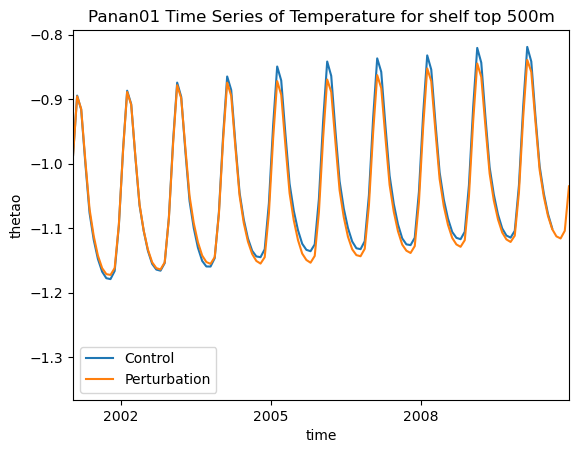

In [12]:
cont01_500_time.plot(label="Control")
pert01_500_time.plot(label="Perturbation")
plt.xlim(380,4000)
plt.legend(loc="lower left")
plt.title("Panan01 Time Series of Temperature for shelf top 500m")

In [11]:
cont01_single = control01_temp.thetao.sel(z_l=500,method='nearest').where(shelf_mask == 1).weighted(areacello01.fillna(0)).mean(dim=('xh','yh'))
pert01_single = trial01_temp.thetao.sel(z_l=500,method='nearest').where(shelf_mask == 1).weighted(areacello01.fillna(0)).mean(dim=('xh','yh'))

In [12]:
cont01_single = cont01_single.load()
pert01_single = pert01_single.load()

Text(0.5, 1.0, 'Panan01 Time Series of Temperature for shelf top 500m')

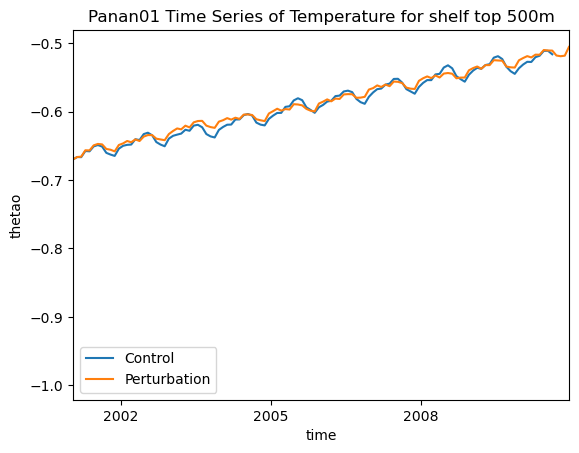

In [13]:
cont01_single.plot(label="Control")
pert01_single.plot(label="Perturbation")
plt.xlim(380,4000)
plt.legend(loc="lower left")
plt.title("Panan01 Time Series of Temperature for shelf top 500m")

Hm maybe not this then, doesn't look great.

In [15]:
anom01_single = pert01_single - cont01_single
anom01_single = anom01_single.load()

### Panan005

In [13]:
depth = data005_fixed.deptho
land_mask = (depth*0).fillna(1)
depth_shelf, shelf_mask = shelf_mask_isobath(depth, 'mom6_005')

In [14]:
## Doing it all at once
#cont005_500_time = control005_temp.thetao.sel(z_l=slice(0,500)).weighted(thick005['z_l'].fillna(0)).mean(dim='z_l').where(shelf_mask == 1).weighted(areacello005.fillna(0)).mean(dim=('xh','yh'))
#pert005_500_time = trial005_temp.thetao.sel(z_l=slice(0,500)).weighted(thick005['z_l'].fillna(0)).mean(dim='z_l').where(shelf_mask == 1).weighted(areacello005.fillna(0)).mean(dim=('xh','yh'))

In [15]:
# Slicing first
cont005_500_time = control005_temp.thetao.sel(time=slice('2001-01','2010-01')).sel(yh=slice(None,-59)).sel(z_l=slice(0,500))
pert005_500_time = control005_temp.thetao.sel(time=slice('2001-01','2010-01')).sel(yh=slice(None,-59)).sel(z_l=slice(0,500))

In [ ]:
cont005_500_time = cont005_500_time.load()
pert005_500_time = pert005_500_time.load()

/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/distributed/client.py:3357: UserWarning: Sending large graph of size 29.51 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


In [ ]:
cont005_500_time = cont005_500_time.weighted(thick005['z_l'].fillna(0)).mean(dim='z_l')
pert005_500_time = pert005_500_time.weighted(thick005['z_l'].fillna(0)).mean(dim='z_l')

In [ ]:
cont005_500_time = cont005_500_time.load()
pert005_500_time = pert005_500_time.load()

In [ ]:
cont005_500_time = cont005_500_time.where(shelf_mask == 1).weighted(areacello005.fillna(0)).mean(dim=('xh','yh'))
pert005_500_time = pert005_500_time.where(shelf_mask == 1).weighted(areacello005.fillna(0)).mean(dim=('xh','yh'))

In [ ]:
cont005_500_time = cont005_500_time.load()
pert005_500_time = pert005_500_time.load()

In [ ]:
cont005_500_time.plot(label="Control")
pert005_500_time.plot(label="Perturbation")
plt.xlim(380,4000)
plt.legend(loc="lower left")
plt.title("Panan005 Time Series of Temperature for shelf top 500m")

Giving up and doing single depth

In [ ]:
cont005_single = control005_temp.thetao.sel(z_l=500,method='nearest').where(shelf_mask == 1).weighted(areacello01.fillna(0)).mean(dim=('xh','yh'))
pert005_single = trial005_temp.thetao.sel(z_l=500,method='nearest').where(shelf_mask == 1).weighted(areacello01.fillna(0)).mean(dim=('xh','yh'))

In [ ]:
cont005_single = cont005_single.load()
pert005_single = pert01_single.load()

In [ ]:
cont005_single.plot(label="Control")
pert005_single.plot(label="Perturbation")
plt.xlim(380,4000)
plt.legend(loc="lower left")
plt.title("Panan005 Time Series of Temperature for shelf top 500m")

In [ ]:
anom005_single = pert005_single - cont005_single
anom005_single = anom005_single.load()

In [ ]:
anom01_single.plot(label="1/10 anomaly"
anom005_single.plot(label="1/20 anomaly")
plt.xlim(380,4000)
plt.legend(loc="lower left")
plt.title("Time Series of Temperature Anomaly for shelf top 500m")